In [55]:
# Hai Duong Nguyen z5521050

Problem context: Time Series Air Quality Prediction with Neural Networks: This assignment involves predicting air quality using neural networks, focusing on two tasks: classification and regression. There are missing values that need to be handled.

=> Use MLP since MLPs are suitable for classification prediction problems where inputs are assigned a class or label.
They are also suitable for regression prediction problems where a real-valued quantity is predicted given a set of inputs.

# Set up environments

In [56]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from google.colab import files

# To ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# # Upload the dataset
# uploaded = files.upload()

# Read the dataset
# df = pd.read_excel(list(uploaded.keys())[0])

# Pre-upload
file_path = r'C:\Users\Nguyen Hai Duong\Desktop\COMP9414 Assignment\AirQualityUCI _ Students.xlsx'
df = pd.read_excel(file_path)

# Data processing
(a) Identify variation range for input and output variables.

In [57]:
# Replace -200 with NaN
df.replace(-200, np.nan, inplace=True)

# Identify variation range for each variable, ignoring NaNs
variation_range = df.agg(['min', 'max']).T
variation_range.columns = ['Min', 'Max']
print(variation_range)

                               Min                  Max
Date           2004-03-10 00:00:00  2005-04-01 00:00:00
Time                      00:00:00             23:00:00
CO(GT)                         0.1                 11.9
PT08.S1(CO)                 647.25              2007.75
NMHC(GT)                       7.0               1189.0
C6H6(GT)                  0.149048            63.741476
PT08.S2(NMHC)               383.25               2214.0
NOx(GT)                        4.0               1479.0
PT08.S3(NOx)                 322.0              2682.75
NO2(GT)                        2.0                339.7
PT08.S4(NO2)                 551.0               2775.0
PT08.S5(O3)                  221.0              2522.75
T                             -1.9                 44.6
RH                           9.175            87.174999
AH                        0.184679             2.231036


(b) Plot each variable to observe the overall behaviour of the process.

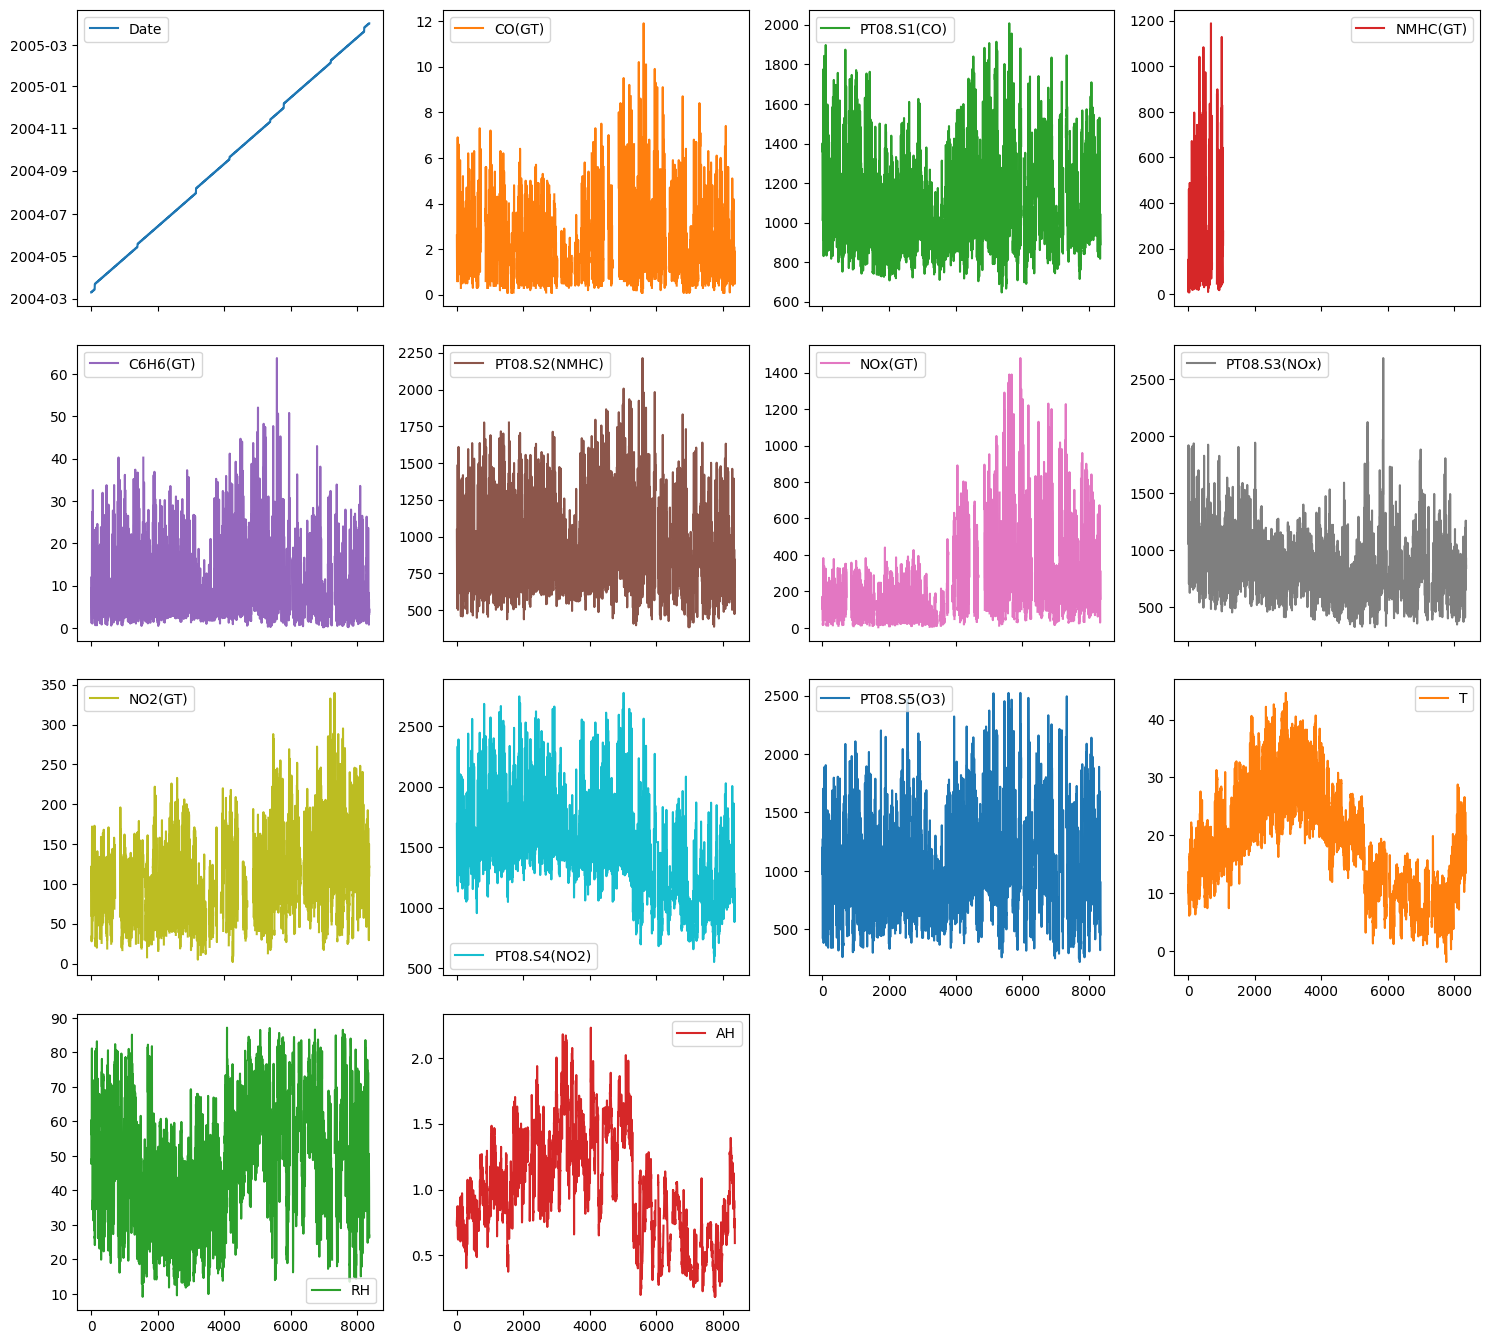

In [58]:
# Plot each variable
df.plot(subplots=True, layout=(6, 4), figsize=(15, 20))
plt.tight_layout()
plt.show()

Based on (a) and (b), we can see some potential outliers as there are many extreme values => Need to handle outliers

We also see some gap in the plot => Need to fill in data for missing values

There might be correlation by observing the patterns suggesting relationships between the variables, which are non-linear (except for the date time).

(c) In case outliers or missing data are detected correct the data accordingly.

*   Missing Data: Missing values marked as -200 are replaced with NaN and then forward filled since this is time-series data
*   Outlier Handling: Z-score method is used to remove outliers with a threshold of 3 standard deviations.



In [59]:
from scipy.stats import zscore

# Handle missing data by forward filling
df.fillna(method='ffill', inplace=True)

# Detect and handle outliers using Z-score method
z_scores = np.abs(zscore(df.select_dtypes(include=np.number)))
df_no_outliers = df[(z_scores < 3).all(axis=1)]

C:\Users\Nguyen Hai Duong\AppData\Local\Temp\ipykernel_6784\2979179863.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


(d) Split the data for training and testing.

From this part, we separate the two tasks.

# Classification Task

Step 1: Select features for Classification

In [60]:
# Feature and target variables for classification
X_class = df_no_outliers.drop(columns=['Date', 'Time', 'CO(GT)', 'NOx(GT)'])
y_class = df_no_outliers['CO(GT)']

Step 2: Split Data into Training and Testing Sets

In this case, 20% of the data will be used for testing, and 80% will be used for training. A fixed random_state is provided to ensure reproducibility of the split.

In [61]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

Step 3: Data normalization

Without normalization, the model might give more weight to the temperature feature because of its larger range.

=> Use fit_transform() to compute the mean and standard deviation of the training data and then transform the training data to a normalized scale

In [62]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

Step 4: Define Threshold for Classification

In [63]:
# Define threshold for classification
threshold = y_train_class.mean()
y_train_class_bin = (y_train_class > threshold).astype(int)
y_test_class_bin = (y_test_class > threshold).astype(int)

Step 5: Design of the neural network

*   In this Classification task, we choose to design 3 layers to match the maximum parameter requirement
*   Activation Function: ReLU is chosen for hidden layers to introduce non-linearity. Sigmoid is used for the output layer as it is a binary classification.
*   Dropout rates of 0.1 => choose low dropout rate to avoid underfitting
*   Optimizer: Adam optimizer is used for its adaptive learning rate capabilities, which helps in faster convergence.
*   Loss Function: Binary cross-entropy is appropriate for binary classification problems.

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Calculate number of samples
number_of_samples = df_no_outliers.shape[0]
max_parameters = number_of_samples / 10
print(f"Maximum allowed number of parameters: {max_parameters}")

# Calculate the input shape
input_shape = X_train_class_scaled.shape[1]

# Build a classification model
model_class = Sequential()
model_class.add(Dense(16, activation='relu', input_shape=(input_shape,)))
model_class.add(Dropout(0.1))
model_class.add(Dense(8, activation='relu'))
model_class.add(Dropout(0.1))
model_class.add(Dense(1, activation='sigmoid'))

# Compile the model
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_class.summary()

# Calculate the number of parameters
total_params_class = model_class.count_params()
print(f"Total number of parameters in classification model: {total_params_class}")

# Check if model satisfies the constraint
if total_params_class < max_parameters:
    print("The network satisfies the maximum number of parameters constraint.")
else:
    print("Check again")

Maximum allowed number of parameters: 776.2
Total number of parameters in classification model: 337
The network satisfies the maximum number of parameters constraint.


C:\Users\Nguyen Hai Duong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 6: Train the Classification model
*  Epochs: 100
*  Batch Size: 3

=> Takes more time but increase the accuracy
*  Validation Split: 10% of the training data is used for validation to monitor performance and avoid overfitting

In [65]:
# Train the classification model
history_class = model_class.fit(X_train_class_scaled, y_train_class_bin, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5324 - loss: 0.6570 - val_accuracy: 0.8712 - val_loss: 0.4532
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8439 - loss: 0.4381 - val_accuracy: 0.8776 - val_loss: 0.3427
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8486 - loss: 0.3782 - val_accuracy: 0.8696 - val_loss: 0.3130
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8460 - loss: 0.3716 - val_accuracy: 0.8728 - val_loss: 0.2989
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.8471 - loss: 0.3646 - val_accuracy: 0.8744 - val_loss: 0.2897
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.8550 - loss: 0.3495 - val_accuracy: 0.8808 - val_loss: 0.2827
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8548 - loss: 0.3434 - val_accuracy: 0.8841 - val_loss: 0.2774
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8540 - loss: 0.3398 - val_

Step 7: Evaluate the Classification model

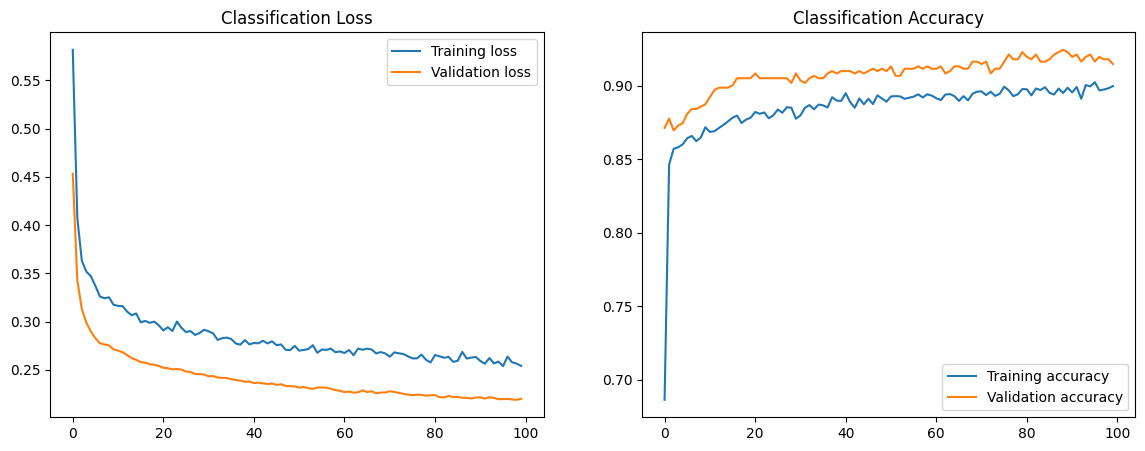

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
----------------------------------------------------------------------
Confusion Matrix     | Positive (Actual) | Negative (Actual)
----------------------------------------------------------------------
Positive (Predicted) | 849               | 79        
Negative (Predicted) | 70                | 555       
----------------------------------------------------------------------

Classification Results
--------------------------------------------------------------------------------
Metric               | Accuracy        | Precision       | Number of Samples   
--------------------------------------------------------------------------------
Value                | 90.41%          | 87.54%          | 1553                
--------------------------------------------------------------------------------


In [66]:
# Plot training history for classification
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['loss'], label='Training loss')
plt.plot(history_class.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Classification Loss')

plt.subplot(1, 2, 2)
plt.plot(history_class.history['accuracy'], label='Training accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Classification Accuracy')

plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_squared_error, mean_absolute_error

# Make predictions and evaluate the model
y_pred_class = (model_class.predict(X_test_class_scaled) > 0.5).astype(int)
cm = confusion_matrix(y_test_class_bin, y_pred_class)
accuracy = accuracy_score(y_test_class_bin, y_pred_class)
precision = precision_score(y_test_class_bin, y_pred_class)

# Display confusion matrix and results
print('-' * 70)
print(f"{'Confusion Matrix':<20} | {'Positive (Actual)':<15} | {'Negative (Actual)':<15}")
print('-' * 70)
print(f"{'Positive (Predicted)':<20} | {cm[0, 0]:<10}        | {cm[0, 1]:<10}")
print(f"{'Negative (Predicted)':<20} | {cm[1, 0]:<10}        | {cm[1, 1]:<10}")
print('-' * 70)

print('\nClassification Results')
print('-' * 80)
print(f"{'Metric':<20} | {'Accuracy':<15} | {'Precision':<15} | {'Number of Samples':<20}")
print('-' * 80)
print(f"{'Value':<20} | {accuracy * 100:.2f}%          | {precision * 100:.2f}%          | {len(y_test_class_bin):<20}")
print('-' * 80)

# Regression Task

Step 1: Select features for Regression

In [67]:
# Feature and target variables for regression
X_reg = df_no_outliers.drop(columns=['Date', 'Time', 'NOx(GT)'])
y_reg = df_no_outliers['NOx(GT)']

Step 2: Split Data into Training and Testing Sets

In [68]:
# Split the data into training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Step 3: Data normalization

In [69]:
# Normalize the data
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

Step 4: Design of the neural network
*  Layers and Units: The network has three layers which are adequate for capturing the relationships in the data without excessive complexity, also to match the requirement of maximum parameters
*  Activation Function: ReLU is chosen for hidden layers to introduce non-linearity.
*  Dropout: Dropout rates of 0.1 => choose low dropout rate to avoid underfitting
*  Optimizer: Adam optimizer is used for its adaptive learning rate capabilities, which helps in faster convergence.
*  Loss Function: Mean squared error is suitable for regression tasks.

In [70]:
# Calculate number of samples (again)
number_of_samples = df_no_outliers.shape[0]
max_parameters = number_of_samples / 10
print(f"Maximum allowed number of parameters: {max_parameters}")

input_shape = X_train_reg_scaled.shape[1]

# Build a regression model
model_reg = Sequential()
model_reg.add(Dense(16, activation='relu', input_shape=(input_shape,)))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(8, activation='relu'))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(1))

# Compile the model
model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# model_reg.summary()

# Calculate the number of parameters
total_params_reg = model_reg.count_params()
print(f"Total number of parameters in regression model: {total_params_class}")

# Check if model satisfies the constraint
if total_params_reg < max_parameters:
    print("The network satisfies the maximum number of parameters constraint.")
else:
    print("Check again")

Maximum allowed number of parameters: 776.2
Total number of parameters in regression model: 337
The network satisfies the maximum number of parameters constraint.


C:\Users\Nguyen Hai Duong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 5: Train the Regression Model

*  Epochs: 50
*  Batch Size: 16

=> To allow the model to learn sufficiently without overfitting, batch size of 16 balances training stability and memory usage. Use less batch size compared to the classification model because errors don't change much as we increase the epochs.
*  Validation Split: 10% of the training data is used for validation to monitor performance and avoid overfitting.

In [71]:
# Train the regression model
history_reg = model_reg.fit(X_train_reg_scaled, y_train_reg, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76426.8672 - mae: 217.7640 - val_loss: 52358.8398 - val_mae: 170.5879
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 37019.1641 - mae: 142.7889 - val_loss: 13170.7979 - val_mae: 83.7905
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14723.5107 - mae: 89.4431 - val_loss: 10003.6953 - val_mae: 72.3047
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12529.3350 - mae: 81.2388 - val_loss: 8342.2695 - val_mae: 65.1640
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 10585.5977 - mae: 73.5223 - val_loss: 7308.2158 - val_mae: 60.6869
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 9726.6719 - mae: 69.6769 - val_loss: 6891.3535 - val_mae: 57.9886
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 9025.7676 - mae: 66.3964 - val_loss: 6385.6265 - val_mae: 56.0362
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8277.0225 - mae: 63.9411 - val_loss: 61

Step 6: Evaluate the Regression model

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Regression Results
--------------------------------------------------------------------------------
Metric          | RMSE            | MAE             | Number of Samples   
--------------------------------------------------------------------------------
Value           | 62.38           | 42.33           | 1553                
--------------------------------------------------------------------------------


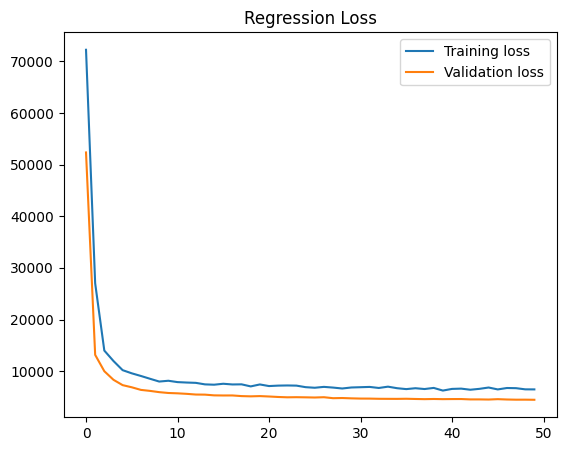

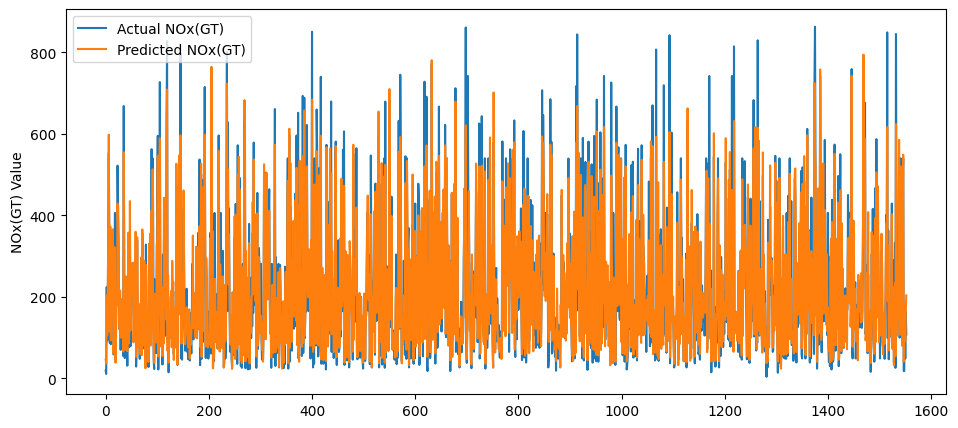

In [72]:
# Plot training history for regression
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training loss')
plt.plot(history_reg.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Regression Loss')

# Plot actual vs predicted values
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 2)
y_pred_reg = model_reg.predict(X_test_reg_scaled)
plt.plot(y_test_reg.values, label='Actual NOx(GT)')
plt.plot(y_pred_reg, label='Predicted NOx(GT)')
plt.legend()
plt.ylabel('NOx(GT) Value')

# Regression Evaluation
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)

# Display regression results
print('\nRegression Results')
print('-' * 80)
print(f"{'Metric':<15} | {'RMSE':<15} | {'MAE':<15} | {'Number of Samples':<20}")
print('-' * 80)
print(f"{'Value':<15} | {rmse:.2f}           | {mae:.2f}           | {len(y_test_reg):<20}")
print('-' * 80)

In [73]:

model_class.save('model_class.weights.h5')
model_reg.save('model_reg.weights.h5')


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import Sequential

from sklearn.preprocessing import StandardScaler

file_path_2 = r'C:\Users\Nguyen Hai Duong\Desktop\COMP9414 Assignment\Generalization Dataset.xlsx'
df = pd.read_excel(file_path_2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)


df.replace(-200, np.nan, inplace=True)

from scipy.stats import zscore


df.fillna(method = 'ffill', inplace=True)

z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
df_no_outliers = df[(z_scores < 3).all(axis=1)]


X_class = df_no_outliers.drop(columns=['Date', 'Time', 'CO(GT)', 'NOx(GT)'])
y_class = df_no_outliers['CO(GT)']


# from sklearn.model_selection import train_test_split
# X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
# # split the data into training and testing data, 20% of the data is used for testing, and 80% is used for training


scalar_class = StandardScaler()
X_class = scalar_class.fit_transform(X_class)


threshold = y_class.mean()
y_class_bin = (y_class > threshold).astype(int)
# define threshold for classification

from keras.models import load_model
model_class = load_model('model_class.weights.h5')


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_squared_error, mean_absolute_error

# Make predictions and evaluate the model
y_pred_class = (model_class.predict(X_class) > 0.5).astype(int)
cm = confusion_matrix(y_class_bin, y_pred_class)
accuracy = accuracy_score(y_class_bin, y_pred_class)
precision = precision_score(y_class_bin, y_pred_class)

# Display confusion matrix and results
print('-' * 70)
print(f"{'Confusion Matrix':<20} | {'Positive (Actual)':<15} | {'Negative (Actual)':<15}")
print('-' * 70)
print(f"{'Positive (Predicted)':<20} | {cm[0, 0]:<10}        | {cm[0, 1]:<10}")
print(f"{'Negative (Predicted)':<20} | {cm[1, 0]:<10}        | {cm[1, 1]:<10}")
print('-' * 70)

print('\nClassification Results')
print('-' * 80)
print(f"{'Metric':<20} | {'Accuracy':<15} | {'Precision':<15} | {'Number of Samples':<20}")
print('-' * 80)
print(f"{'Value':<20} | {accuracy * 100:.2f}%          | {precision * 100:.2f}%          | {len(y_class_bin):<20}")
print('-' * 80)

C:\Users\Nguyen Hai Duong\AppData\Local\Temp\ipykernel_6784\927288033.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = 'ffill', inplace=True)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
----------------------------------------------------------------------
Confusion Matrix     | Positive (Actual) | Negative (Actual)
----------------------------------------------------------------------
Positive (Predicted) | 436               | 51        
Negative (Predicted) | 41                | 291       
----------------------------------------------------------------------

Classification Results
--------------------------------------------------------------------------------
Metric               | Accuracy        | Precision       | Number of Samples   
--------------------------------------------------------------------------------
Value                | 88.77%          | 85.09%          | 819                 
--------------------------------------------------------------------------------


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step

Regression Results
--------------------------------------------------------------------------------
Metric          | RMSE            | MAE             | Number of Samples   
--------------------------------------------------------------------------------
Value           | 65.61           | 43.79           | 819                 
--------------------------------------------------------------------------------


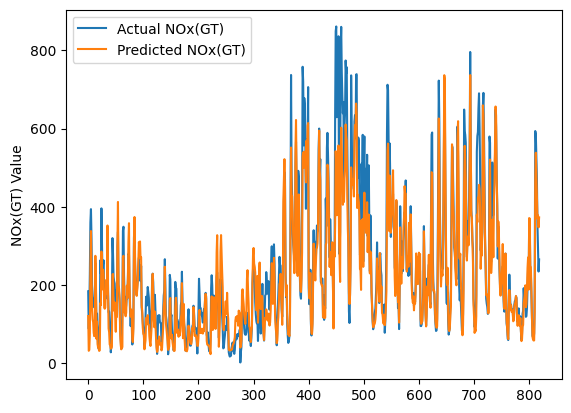

: 

In [75]:
X_reg = df_no_outliers.drop(columns=['Date', 'Time', 'NOx(GT)'])
y_reg = df_no_outliers['NOx(GT)']
# Normalize the data
scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(X_reg)
input_shape = X_reg.shape[1]
# Build a regression model
model_reg = load_model('model_reg.weights.h5')



y_pred_reg = model_reg.predict(X_reg)
# Regression Evaluation
rmse = np.sqrt(mean_squared_error(y_reg, y_pred_reg))
mae = mean_absolute_error(y_reg, y_pred_reg)

y_pred_reg = model_reg.predict(X_reg)
plt.plot(y_reg.values, label='Actual NOx(GT)')
plt.plot(y_pred_reg, label='Predicted NOx(GT)')
plt.legend()
plt.ylabel('NOx(GT) Value')

# Regression Evaluation
rmse = np.sqrt(mean_squared_error(y_reg, y_pred_reg))
mae = mean_absolute_error(y_reg, y_pred_reg)

# Display regression results
print('\nRegression Results')
print('-' * 80)
print(f"{'Metric':<15} | {'RMSE':<15} | {'MAE':<15} | {'Number of Samples':<20}")
print('-' * 80)
print(f"{'Value':<15} | {rmse:.2f}           | {mae:.2f}           | {len(y_reg):<20}")
print('-' * 80)